In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
dev = 'cpu'
import math
# Cool resources about autoregressive models
# https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/
# https://dida.do/blog/temporal-convolutional-networks-for-sequence-modeling

# Autoregressive modeling

$N$ dimensional input with lag $P$.

$\hat{y}_t = f(y_{t-1},y_{t-2},...,y_{t-P})$

We can model this with a fully connected layer

\begin{equation}
X_t | X_{i<t} = \theta_0 + \sum^P_{i=i}{\theta_i X_{t-i}}
\end{equation}

And the whole system as a DNN with nonlinearity $\delta(.)$ at the $l^{th}$ layer:

\begin{equation}
H^l_t = \sigma(\Theta^{l-1}_t\cdot H_t^{l-1})
\end{equation}

# Limitations of fully connected layers
#### 1. **Training** with linear layers is inefficient as autoregressive value needs to be computed for every possible window of size $P$.

This means that we don't have weight preloading strategies like in the case of CNNs. To generate an output in a CNN, we compute the intermediate outputs of a layer for all the sequence before computing the next one. This means that we can implement training un-rolling (since we know the future data points at train time) and avoid computing a single forward pass for every input before processing next one. 

A CNN that implements **casual** processing of inputs is called TCN.

#### 2. The number of weights grows linearily with the receptive field of the model. For multi-time scale models (speech, audio) this becomes quickly an issue.

Fully connected layers don't have implemented downsampling methods such as dilation or stride that would increase receptive field without increasing the number of parameters.

# Graphical model MLPs vs CNNs

# A harmonic series dataset

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [2]:
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(harmonics*torch.sin(self.phases))
        return sample

Let's generate a dataset and plot its content.

240
240


/tools/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


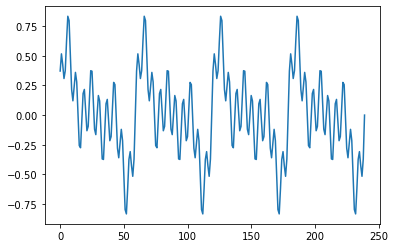

In [3]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
dataset = HarmonicSeriesDataset(harmonics,n_periods)
dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(dataloader)
print(period_len*n_periods)
print(signal_len)
samples = torch.zeros(signal_len)

for i,sample in enumerate(dataloader):
    samples[i] = sample
fig, ax = plt.subplots()
ax.plot(samples.detach().numpy())
plt.show()

# Autoregressive MLP module

In [4]:
class autoregressiveMLP(nn.Module):
    def __init__(self,in_size,seq_len,hidden_layers,hidden_size,device,use_bias = True):
        super().__init__()
        
        total_in_size = in_size * seq_len
        out_size = in_size
        net = []
        if(hidden_layers == 0):
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
            #net.append(nn.Tanh())
        else:
            net.append(nn.Linear(total_in_size,hidden_size,bias=use_bias))
            net.append(nn.ReLU())
            for i in range(hidden_layers):
                net.append(nn.Linear(hidden_size,hidden_size,bias=use_bias))
                net.append(nn.ReLU())
            net.append(nn.Linear(hidden_size,out_size,bias=use_bias))
            #net.append(nn.Tanh()) # Works better with identity for the toy example
        
        self.net = nn.Sequential(*net)

    '''
    Updates circular buffer with new item and process output
    The model predicts x_n from a collection of previous entries.
    Forward process:
        circular buffer contains all prev samples in this order: 
        [x_{n-1} , x_{n-2}, ... , x_{n-P}]
        1. Predict next output from current collection of prev samples.
        2. Update buffer with either current sample or force the correct value.
        3. Return prediction
    
        I think this is wrong
        # Roll and detach previous grad (otherwise it computes all grads through time)
            self.seq = torch.roll(self.seq,1,0).detach()
            self.seq[0,:] = item
            #print(self.seq.view(-1))
            return self.net(self.seq.view(-1))
    
    '''
    def forward(self,seq):
        ''' 

        '''
        #print("net input: {}".format(self.seq.view(-1)))
        pred = self.net(seq.view(-1))
        return pred

# Training and Evaluation function

In [5]:
def mlp_evaluate_on_train_data(net,P,target,device,plot=False):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    with torch.no_grad():
        for i, sample in enumerate(target):
            sample = sample.to(device)
            pred = net(seq)
            predictions[i] = pred
            seq = torch.roll(seq,1,0)
            seq[0] = sample # Teacher forcing
            seq.detach()

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON TRAIN DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().numpy())
        ax.plot(predictions.detach().numpy())
        plt.show()
    return eval_loss
    
def mlp_evaluate_dry(net,P,target,device,plot=False):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    with torch.no_grad():
        for i in range(target_len):
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[i]
            seq.detach()

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[DRY TEST] eval loss {}".format(eval_loss))        
        ax.plot(target.detach().cpu().numpy())
        ax.plot(predictions.detach().cpu().numpy())
        plt.show()
    return eval_loss

def mlp_evaluate_section(net,P,target,section,device):
    target_len = target.size()[0]
    predictions = torch.zeros(target_len)
    seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data
    l1 = int(target_len*section)
    l2 = target_len - l1
    with torch.no_grad():
        for i in range(l1):
            sample = target[i].to(device)
            predictions[i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = sample # Teacher forcing
            seq.detach()
        # print("At {}, we have in sequence:".format(section))
        # fig, ax = plt.subplots()
        # ax.plot(seq.detach().cpu().numpy())
        # plt.show()
        # Continue predicting without previous reference
        for i in range(l2):
            predictions[l1 + i] = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = predictions[l1 + i] # No teacher forcing
            seq.detach()

    l1_diff = torch.abs(target-predictions)
    eval_loss = torch.sum(l1_diff)
    print("[SECTION TEST] eval loss {}".format(eval_loss))
    fig, ax = plt.subplots()
    ax.plot(target.detach().cpu().numpy())
    ax.plot(predictions.detach().cpu().numpy())
    plt.show()
    # Show error over time
    fig, ax = plt.subplots()
    ax.plot(l1_diff.detach().cpu().numpy())
    ax.plot(predictions.detach().cpu().numpy())
    plt.show()
    
    
def mlp_train(net,P,epochs,dataloader,target,device,teacher_force = False):
    net.train()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    best_eval_loss = np.inf
    #   If I declare the buffer here, then it will have signal present at the
    #   beggining of all epochs except epoch 0. It will be more difficult 
    #   for the model to kickstart its prediction cause it does not overfit 
    #   to the case where it has all zeroes and starts predicting from scratch.
    
    #seq = torch.zeros([P]).to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        seq = torch.zeros([P]).to(device) # Circular buffer to hold previous data        
        for i, sample in enumerate(dataloader):
            sample = sample.to(device)
            optimizer.zero_grad()
            # forward + backward + optimize
            prediction = net(seq)
            seq = torch.roll(seq,1,0)
            seq[0] = sample if teacher_force else prediction
            seq.detach()

            loss = criterion(prediction, sample)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()


        eval_loss = mlp_evaluate_dry(net,P,target,device)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(net.state_dict(), 'best_mlp.pt')
            
        if(epoch % 50 == 0): 
            #fig, ax = plt.subplots()
            #ax.plot(net.seq.detach().numpy())
            #plt.show()
            print("[EPOCH {}] train loss {} - best eval {}".format(epoch,running_loss,best_eval_loss))
            #net.eval()

            #evaluate_on_train_data(net,target)
            
            #net.train()
        running_loss = 0.0

    print('Finished Training')


# Training the MLP

Here, if we don't use `teacher_forcing` then the model does not train.
I believe we may not have to `.detach()` the circular buffer for every new sample we input, this way we would be able to effectively backpropagate through time. Problem is, this constructs very complex gradient trees.

In [6]:
def train_and_test_MLP(P,hidden_size,n_hidden_layers,dataloader,epochs,device,eval_section=0.5):
    #EPOCHS = 400
    # Declare a MLP model
    #seq_length = 100
    #hidden_size = 32
    #n_layers = 3
    samples = torch.zeros(len(dataloader))
    for i,sample in enumerate(dataloader):
        samples[i] = sample

    in_size = 1
    
    net = autoregressiveMLP(in_size,P,n_hidden_layers,hidden_size,device)
    net = net.to(device)
    
    teacher_force = True
    mlp_train(net,P,epochs,dataloader,samples,device,teacher_force)
    
    net.load_state_dict(torch.load('best.pt'))
    net.eval()
    mlp_evaluate_on_train_data(net,P,samples,device,plot=True)
    
    mlp_evaluate_dry(net,P,samples,device,plot=True)
    
    mlp_evaluate_section(net,P,samples,eval_section,device)

[EPOCH 0] train loss 53.84253785246983 - best eval 60.80059814453125
[EPOCH 50] train loss 9.321611875668168 - best eval 25.809772491455078
Finished Training
[TEST ON TRAIN DATA] eval loss 10.101298332214355


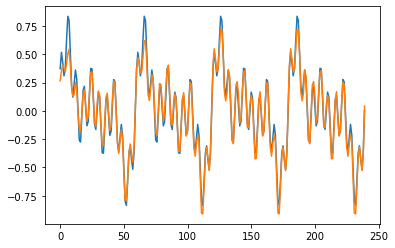

[DRY TEST] eval loss 25.809772491455078


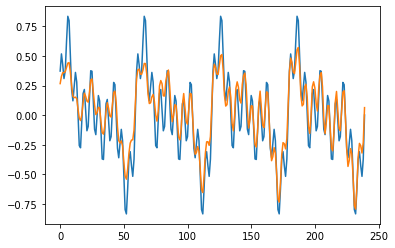

[SECTION TEST] eval loss 11.727523803710938


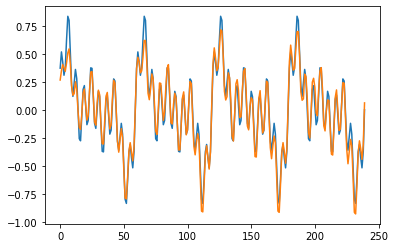

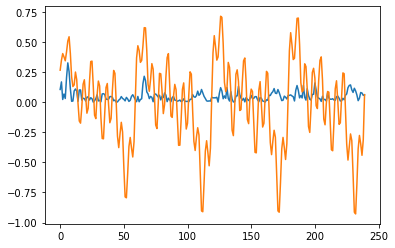

In [7]:
train_and_test_MLP(100,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)


[EPOCH 0] train loss 60.864255322143435 - best eval 74.39726257324219
[EPOCH 50] train loss 10.663768314756453 - best eval 49.71159362792969
Finished Training
[TEST ON TRAIN DATA] eval loss 17.007062911987305


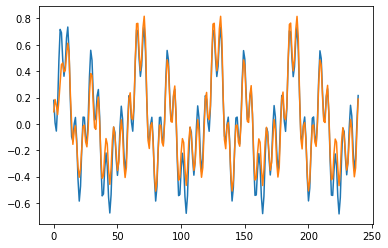

[DRY TEST] eval loss 49.71159362792969


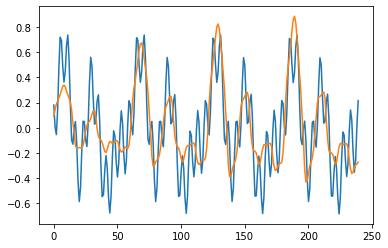

[SECTION TEST] eval loss 24.052265167236328


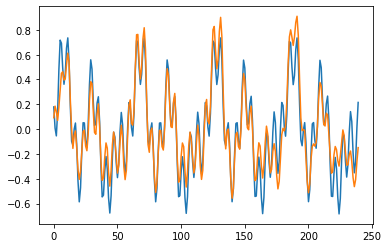

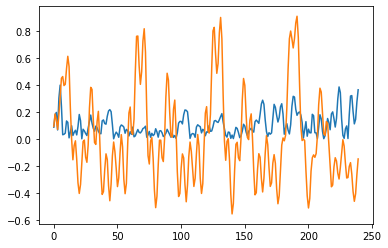

In [8]:
train_and_test_MLP(50,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 65.68071024678648 - best eval 72.62120819091797
[EPOCH 50] train loss 10.317044027149677 - best eval 67.66856384277344
Finished Training
[TEST ON TRAIN DATA] eval loss 18.732524871826172


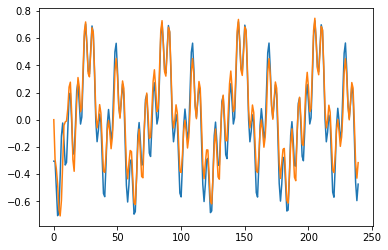

[DRY TEST] eval loss 66.96166229248047


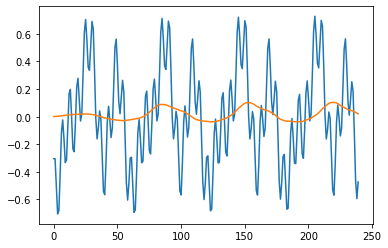

[SECTION TEST] eval loss 68.00688934326172


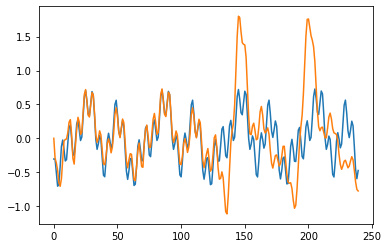

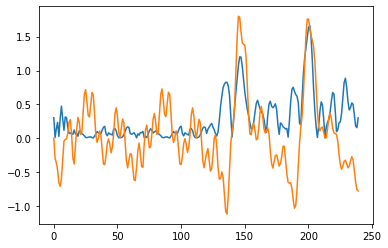

In [9]:
train_and_test_MLP(20,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

In [10]:
train_and_test_MLP(10,32,3,dataloader,epochs=100,device=dev,eval_section=0.5)

[EPOCH 0] train loss 56.79264663904905 - best eval 84.303955078125


KeyboardInterrupt: 

In [ ]:
train_and_test_MLP(10,128,3,dataloader,epochs=100,device=dev,eval_section=0.5)

# TCN: Temporal Convolutional Network

## Causal convolution layer
To obtain a causal conv layer, we have to add zero-padding to the left. The amount of padding needed depends of the kernel size $k$ and dilation factor $b$.

\begin{equation}
p = b \cdot (k-1)
\end{equation}

We create a class inheriting from `torch.nn.Conv1d` and apply only left padding to the input.

In [75]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True,
                 apply_padding=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.apply_padding = apply_padding
        self.__padding = dilation*(kernel_size - 1)
        
    def forward(self, input):
        # Apply left padding using torch.nn.functional and then compute conv.
        if(self.apply_padding):
            return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))
        else:
            return super(CausalConv1d, self).forward(input)

## TCN Residual Block

A causal convolutional layer will output the same sequence length as the input one. The TCN Residual block also outputs the same length. But, even though we have an output sequence the same size as the input one, this does not guarantee that we will take into account a specific sequence coverage. Therefore, the last question that remains is how to ensure **full sequence coverage**.

Full sequence coverage means that the receptive field is big enough to address the full desired sequence length we have to take into account.

<img src="https://unit8.com/wp-content/uploads/2021/07/image-49.png" width="600">

Image source: https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/

In [203]:
class TCN_block(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,kernel_size,stride=1,dilation=1,apply_padding=True,last_block=False):
        super().__init__()
        block = []
        cnv1 = CausalConv1d(in_channels,hidden_channels,kernel_size,stride=stride,dilation=dilation,apply_padding=apply_padding)
        block.append(torch.nn.utils.weight_norm( cnv1 ) )
        block.append(nn.ReLU())
        block.append(nn.Dropout())
        
        cnv2 = CausalConv1d(hidden_channels,out_channels,kernel_size,stride=stride,dilation=dilation,apply_padding=apply_padding)
        block.append(torch.nn.utils.weight_norm( cnv2 ) )
        if(last_block == False):
            block.append(nn.ReLU())
            block.append(nn.Dropout())
        
        self.block = nn.Sequential(*block)
        
        #self.residual = nn.Conv1d(in_channels,out_channels,1,padding = 0,stride=stride)
    
    def forward(self,data):
        block_out = self.block(data)
        #residual = self.residual(data)
        #print("block_out {} - residual {}".format(block_out.size(),residual.size()))
        #return block_out + residual
        return block_out

## TCN Network

The receptive field of a TCN with $n$ blocks, kernel size of $k$, and dilation base of $b$ is given by:
\begin{equation}
r = 1 + 2 \cdot (k-1) \cdot \frac{b^n-1}{b-1}
\end{equation}

Given a desired coverage $l$ of the input, a dilation base $b$, and a kernel size base of $k \geq b$, the number of residual block $n$ required to guarantee the coverage is given by:
\begin{equation}
n = log_b(\frac{(l-1)\cdot(b-1)}{(k-1) \cdot 2} + 1)
\end{equation}

In [204]:
class TCN_net(nn.Module):
    def __init__(self,n_blocks,in_channels,hidden_channels,out_channels,kernel_size,dilation_base,apply_padding=True):
        super().__init__()
        base = 0
        net = []

        net.append(TCN_block(in_channels,hidden_channels,hidden_channels,kernel_size,dilation=dilation_base**base,apply_padding=apply_padding))
        if(n_blocks>2):
            for i in range(n_blocks-2):
                base += 1
                net.append(TCN_block(hidden_channels,hidden_channels,hidden_channels,kernel_size,dilation=dilation_base**base,apply_padding=apply_padding))
        
        base += 1
        net.append(TCN_block(hidden_channels,hidden_channels,out_channels,kernel_size,dilation=dilation_base**base,apply_padding=apply_padding,last_block=True))

        self.net = nn.Sequential(*net)
    
    def forward(self,in_sequence):
        return self.net(in_sequence)


# Training the TCN

In [278]:
def tcn_evaluate_on_data(net,eval_data,target,device,plot=False):
    with torch.no_grad():
        eval_data = eval_data.to(device)
        predictions = net(eval_data)

    eval_loss = torch.sum(torch.abs(target-predictions))
    if(plot):
        fig, ax = plt.subplots()
        print("[TEST ON DATA] eval loss {}".format(eval_loss))        
        ax.plot(target.view(-1).detach().numpy())
        ax.plot(predictions.view(-1).detach().numpy())
        plt.show()
    return eval_loss

def tcn_train(net,epochs,train_data,target,device):
    net.train()
    criterion = nn.L1Loss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    best_eval_loss = np.inf
    #   If I declare the buffer here, then it will have signal present at the
    #   beggining of all epochs except epoch 0. It will be more difficult 
    #   for the model to kickstart its prediction cause it does not overfit 
    #   to the case where it has all zeroes and starts predicting from scratch.
    
    #seq = torch.zeros([P]).to(device)
    train_data = train_data.to(device)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        optimizer.zero_grad()
        # forward + backward + optimize
        prediction = net(train_data)

        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()


        #eval_loss = evaluate_dry(net,P,samples,device)
        eval_loss = tcn_evaluate_on_data(net,train_data,target,device)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            torch.save(net.state_dict(), 'best_tcn.pt')

        if(epoch % 1000 == 0 and epoch != 0): 
            eval_loss = tcn_evaluate_on_data(net,train_data,target,device,plot=True)
            
        if(epoch % 100 == 0 and epoch != 0): 
            #fig, ax = plt.subplots()
            #ax.plot(net.seq.detach().numpy())
            #plt.show()
            print("[EPOCH {}] train loss {} - best eval {}".format(epoch,running_loss,best_eval_loss))
            #net.eval()

            #evaluate_on_train_data(net,target)
            
            #net.train()
        running_loss = 0.0

    print('Finished Training')

In [279]:
def train_and_test_TCN(n_blocks,in_channels,hidden_channels,out_channels,kernel_size,dilation_base,train_data,target,epochs,device):

    net = TCN_net(n_blocks,in_channels,hidden_channels,out_channels,kernel_size,dilation_base)
    net = net.to(device)
    
    tcn_train(net,epochs,train_data,target,device)
    
    tcn_evaluate_on_data(net,train_data,target,device,plot=True)

## TCN Training problem

Let's train this net to predict an output $A$ samples ahead.

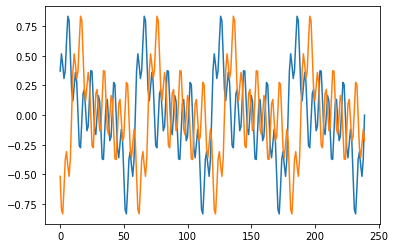

In [280]:
A = 10
train_samples = samples.unsqueeze(0).unsqueeze(0)
test_samples = torch.roll(train_samples,A,2)

plt.show()

fig, ax = plt.subplots()
ax.plot(train_samples.view(-1).detach().cpu().numpy())
ax.plot(test_samples.view(-1).detach().cpu().numpy())
plt.show()

Receptive field: 29.0
N_layers : 3
[EPOCH 100] train loss 0.1580388993024826 - best eval 36.94145202636719
[EPOCH 200] train loss 0.13165424764156342 - best eval 31.244918823242188
[EPOCH 300] train loss 0.13761593401432037 - best eval 26.917469024658203
[EPOCH 400] train loss 0.11299096792936325 - best eval 26.657371520996094
[EPOCH 500] train loss 0.11429282277822495 - best eval 25.63263511657715
[EPOCH 600] train loss 0.11309809237718582 - best eval 24.66399383544922
[EPOCH 700] train loss 0.11259368807077408 - best eval 23.95536994934082
[EPOCH 800] train loss 0.10965123027563095 - best eval 23.009790420532227
[EPOCH 900] train loss 0.10270363837480545 - best eval 22.740894317626953
[TEST ON DATA] eval loss 27.14494514465332


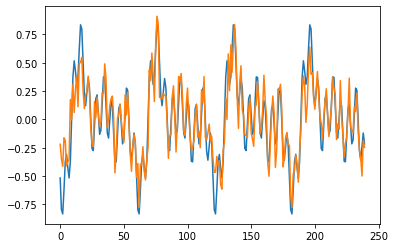

[EPOCH 1000] train loss 0.0995694026350975 - best eval 22.182262420654297
[EPOCH 1100] train loss 0.10957502573728561 - best eval 22.182262420654297
[EPOCH 1200] train loss 0.10358912497758865 - best eval 20.941659927368164
[EPOCH 1300] train loss 0.10301187634468079 - best eval 20.941659927368164
[EPOCH 1400] train loss 0.1011195033788681 - best eval 20.746116638183594
[EPOCH 1500] train loss 0.09983811527490616 - best eval 20.746116638183594
[EPOCH 1600] train loss 0.09105897694826126 - best eval 19.568580627441406
[EPOCH 1700] train loss 0.10441016405820847 - best eval 19.568580627441406
[EPOCH 1800] train loss 0.08926742523908615 - best eval 19.568580627441406
[EPOCH 1900] train loss 0.10247362405061722 - best eval 19.568580627441406
Finished Training
[TEST ON DATA] eval loss 22.476261138916016


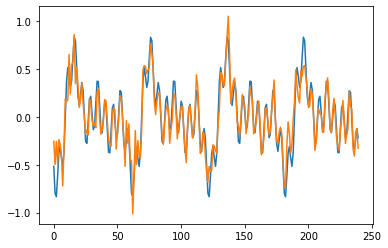

In [281]:
dilation_base = 2
kernel_size = 3
n_blocks = 3
dilation_factor = (dilation_base**n_blocks-1)/(dilation_base-1)
P = 1 + 2*(kernel_size-1)*dilation_factor
print("Receptive field: {}".format(P))

arg = ( (P-1)*(dilation_base-1) )/( (kernel_size-1)*2 )
n = int(math.log(arg, dilation_base) + 1)
print("N_layers : {}".format(n))

train_and_test_TCN(n_blocks,1,32,1,kernel_size,dilation_base,train_data=train_samples,target=test_samples,epochs=2000,device=dev)

In [282]:

net = TCN_net(n_blocks,1,32,1,kernel_size,dilation_base,apply_padding=False)
net.load_state_dict(torch.load('best_tcn.pt'))
net.eval()
b = torch.zeros(int(P)).unsqueeze(0).unsqueeze(0)

print(net(b).size())

torch.Size([1, 1, 1])
